In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [37]:
# GLOBAL VARS
n_time_steps = 2
future_preds = 7

In [3]:
yesterday = datetime.now() - timedelta(days=1)
curr_year = yesterday.year
curr_month = yesterday.strftime("%b")
curr_day = yesterday.day
#f'{curr_day}{curr_month}{curr_year}'

In [31]:
pd.read_csv('./Data/bitcoin-03Feb2024.csv').head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 03, 2024","43,070.1","43,194.7","43,370.4","42,974.2",32.15K,-0.29%
1,"Feb 02, 2024","43,194.7","43,083.7","43,459.3","42,596.3",42.65K,0.26%
2,"Feb 01, 2024","43,081.4","42,580.1","43,263.1","41,890.5",47.69K,1.18%
3,"Jan 31, 2024","42,580.5","42,946.2","43,739.7","42,315.4",56.48K,-0.85%
4,"Jan 30, 2024","42,946.2","43,303.3","43,817.9","42,702.9",55.13K,-0.82%


In [4]:
raw_data = pd.read_csv('./Data/bitcoin-03Feb2024.csv')
raw_data['Multiplier'] = raw_data['Vol.'].apply(lambda x: 1000 if 'K' in x else (1000000 if 'M' in x else 1000000000))
def preprocessing(raw_data):
    data = raw_data
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Month'] = data['Month'].astype(str).str.zfill(2)
    data['Year'] = data['Date'].dt.year
    data['Price'] = data['Price'].apply(lambda x: x.replace(',', '')).astype(float).round(2)
    data['Open'] = data['Open'].apply(lambda x: x.replace(',', '')).astype(float).round(2)
    data['High'] = data['High'].apply(lambda x: x.replace(',', '')).astype(float).round(2)
    data['Low'] = data['Low'].apply(lambda x: x.replace(',', '')).astype(float).round(2)
    data['Change %'] = data['Change %'].apply(lambda x: x.replace('%', '')).astype(float)
    data['Vol.'] = data['Vol.'].apply(lambda x: x.replace('K', '').replace('M', '').replace('B','')).astype(float)
    data['Vol.'] = data['Vol.'] * data['Multiplier']
    data = data.sort_values(by=['Date']).reset_index(drop=True)
    return data[['Date', 'Price']]
processed = preprocessing(raw_data)
processed

,Date,Price
0,2014-01-01,815.9
1,2014-01-02,856.9
2,2014-01-03,884.3
3,2014-01-04,924.7
4,2014-01-05,1014.7
...,...,...
3681,2024-01-30,42946.2
3682,2024-01-31,42580.5
3683,2024-02-01,43081.4
3684,2024-02-02,43194.7


In [5]:
final_data = processed.copy(deep=True)

In [6]:
final_data.columns

Index(['Date', 'Price'], dtype='object')

In [7]:
def prepare_lstm_data(df, input_features=['Price'], 
                      target_feature='Price', time_steps=10):
    """
    Prepare data for LSTM training.

    Parameters:
    - df: DataFrame with daily-level bitcoin prices.
    - input_features: List of feature columns to be used as input for the LSTM model.
    - target_feature: The target feature column to be predicted.
    - time_steps: Number of past days to use as input for predicting the next day.

    Returns:
    - X: Input data in the shape (NUMBER_OF_SAMPLES, TIME_PERIOD, FEATURES).
    - y: Target data for prediction.
    """
    
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1,1))
    
    # Select relevant columns
    selected_columns = input_features
    df_selected = df[selected_columns].copy()
    pickle.dump(scaler, open('./scaler', 'wb'))
    # Create sequences of input data and target values
    sequences, targets = [], []

    for i in range(len(df_selected) - time_steps):
        seq = df_selected.iloc[i:i + time_steps][input_features].values
        target = df_selected.iloc[i + time_steps][target_feature]
        sequences.append(seq)
        targets.append(target)

    X = np.array(sequences)
    y = np.array(targets)

    return X, y

# Example usage:
# Assuming your DataFrame is named 'bitcoin_data'
# Adjust the parameters as needed, e.g., time_steps, input_features, target_feature
X, y = prepare_lstm_data(final_data, time_steps=n_time_steps)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3684, 2, 1)
Shape of y: (3684,)


In [33]:
y[0]

0.011461619815979223

In [8]:
def time_based_train_test_split(X, y, test_size=0.2):
    """
    Time-based train-test split for LSTM data.

    Parameters:
    - X: Input data.
    - y: Target data.
    - test_size: Proportion of the dataset to include in the test split.

    Returns:
    - X_train, X_test, y_train, y_test: Train and test sets for X and y.
    """

    # Calculate the split index
    split_index = int(len(X) * (1 - test_size))

    # Split the data
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = time_based_train_test_split(X, y, test_size=0.2)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2947, 2, 1)
Shape of y_train: (2947,)
Shape of X_test: (737, 2, 1)
Shape of y_test: (737,)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Assuming you have already loaded and prepared your data as X and y


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=300, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=True))
model.add(LSTM(units=200, activation='relu', return_sequences=True))
model.add(LSTM(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1, activation='softplus'))  # Output layer with one neuron for regression

custom_optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='logcosh', metrics=['mean_absolute_percentage_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

Train on 2947 samples
Epoch 1/25
2947/2947 [==============================] - 6s 2ms/sample - loss: 0.1600 - mean_absolute_percentage_error: 243344.9375
Epoch 2/25
2947/2947 [==============================] - 2s 635us/sample - loss: 0.1491 - mean_absolute_percentage_error: 240067.8594
Epoch 3/25
2947/2947 [==============================] - 2s 643us/sample - loss: 0.1275 - mean_absolute_percentage_error: 220295.8906
Epoch 4/25
2947/2947 [==============================] - 2s 640us/sample - loss: 0.0823 - mean_absolute_percentage_error: 196114.8281
Epoch 5/25
2947/2947 [==============================] - 2s 635us/sample - loss: 0.0372 - mean_absolute_percentage_error: 116954.5156
Epoch 6/25
2947/2947 [==============================] - 2s 633us/sample - loss: 0.0230 - mean_absolute_percentage_error: 54139.2227
Epoch 7/25
2947/2947 [==============================] - 2s 639us/sample - loss: 0.0121 - mean_absolute_percentage_error: 55475.0742
Epoch 8/25
2947/2947 [=============================

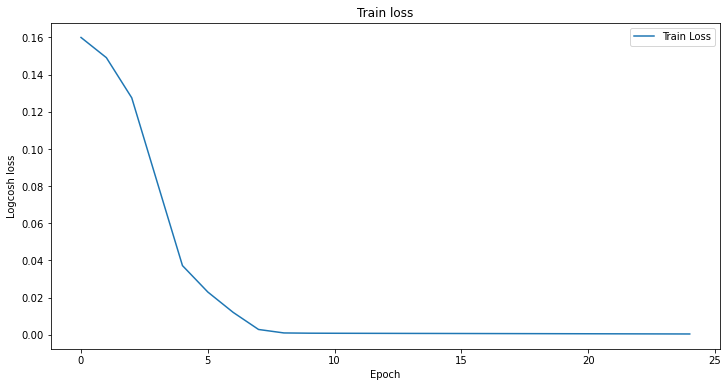

In [34]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Logcosh loss')
plt.show()

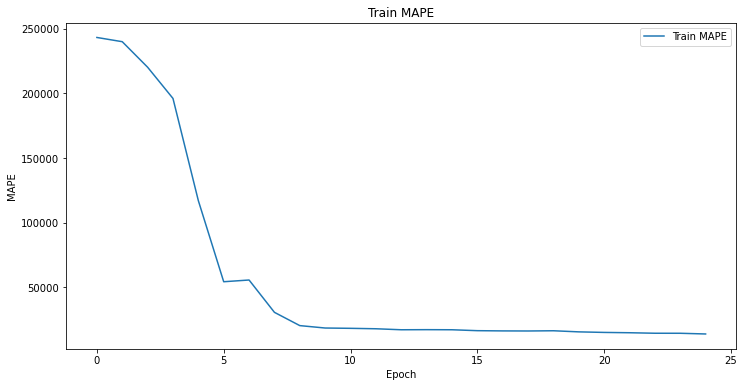

In [35]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE')
#plt.plot(history.history['val_mean_absolute_percentage_error'], label='Val MAPE')
plt.title('Train MAPE')
plt.legend()
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.show()

In [15]:
# Load scaler object
scaler = pickle.load(open('./scaler', 'rb'))

# Evaluate the model on the test set
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

# Reverse the normalization
test_pred = scaler.inverse_transform(test_pred)
train_pred = scaler.inverse_transform(train_pred)

y_test_inv = scaler.inverse_transform(y_test.reshape((-1,1)))
y_train_inv = scaler.inverse_transform(y_train.reshape((-1,1)))


# Calculate Mean Squared Error
mse = mean_squared_error(y_test_inv, test_pred)
mape = mean_absolute_percentage_error(y_test_inv, test_pred)
print("Mean Squared Error on Test Set:", mse)
print(f"Mean Absolute Percentage Error: {round(mape,2)}%")

Mean Squared Error on Test Set: 3574302.901974029
Mean Absolute Percentage Error: 0.06%


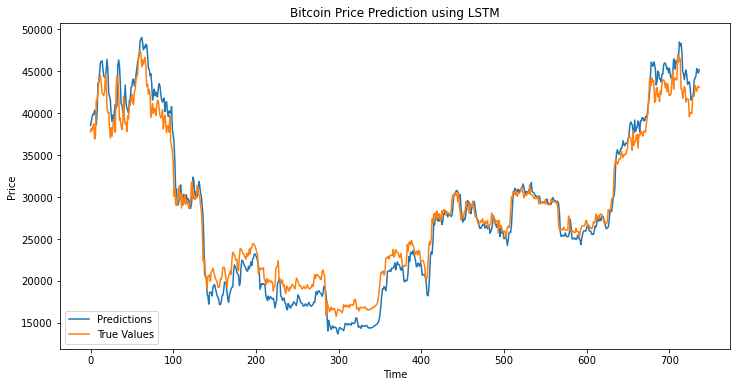

In [16]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test_pred, label='Predictions')
plt.plot(y_test_inv, label='True Values')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

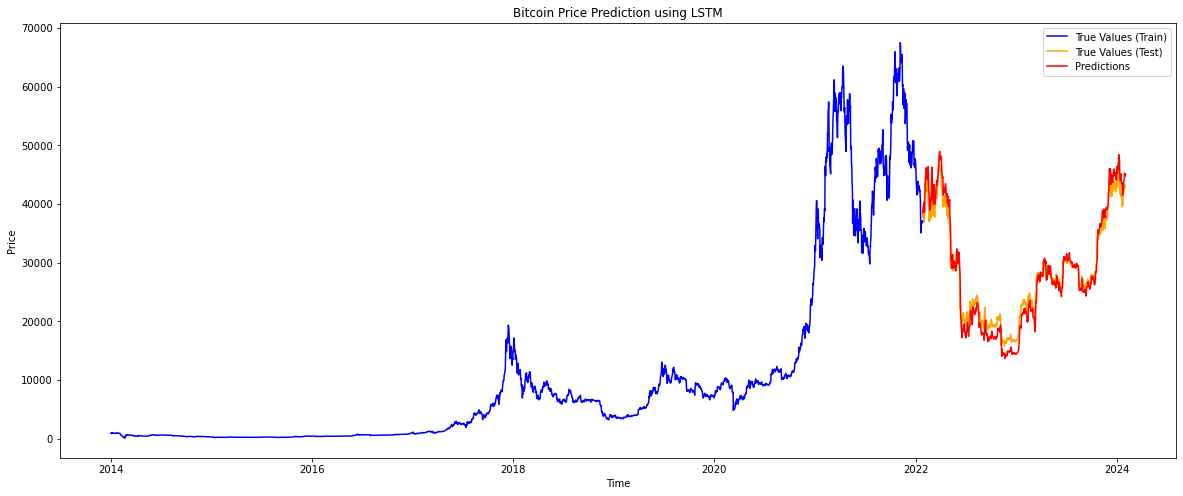

In [18]:
#x = [i for i in range(0, y_train.shape[0]+y_pred.shape[0])]
ticks = pd.to_datetime(final_data['Date']).dt.date.tolist()[:-n_time_steps]

plt.figure(figsize=(20, 8))
# Plot y_train with blue color
plt.plot(ticks[:y_train.shape[0]], y_train_inv, label='True Values (Train)', color='blue')

# Plot y_pred with orange color
plt.plot(ticks[y_train.shape[0]:], y_test_inv, label='True Values (Test)', color='orange')

# Plot y_test with red color
plt.plot(ticks[y_train.shape[0]:], test_pred, label='Predictions', color='red')

plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
#plt.xticks(ticks, rotation = 90, fontsize=3)
plt.legend()
plt.show()

In [19]:
# Save the trained model to a file
model.save('./bitcoin_lstm_univariate.h5')

In [38]:
# Predict future values
def predict_future_prices(model_path, historical_data, num_days):
    """
    Predict future Bitcoin prices using an LSTM model.

    Parameters:
    - model_path: Path to the pre-trained LSTM model file.
    - historical_data: DataFrame with historical Bitcoin prices.
    - num_days: Number of days for future predictions.

    Returns:
    - DataFrame with predicted future Bitcoin prices.
    """

    # Load the pre-trained LSTM model
    model = load_model(model_path)
    
    #actuals = historical_data[historical_data['Date'] > (historical_data['Date'].max() - timedelta(days=num_days))]['Price'].tolist()
    #actuals = np.array(actuals)
    
    # Extract the necessary features from historical data
    #historical_data = historical_data[historical_data['Date'] <= (historical_data['Date'].max() - timedelta(days=num_days))].reset_index(drop=True)
    features = historical_data['Price'].values.reshape(-1, 1)


    # Create sequences for prediction
    sequences = []

    for i in range(len(features) - n_time_steps):
        sequence = features[i:i+n_time_steps]
        sequences.append(sequence)

    sequences = np.array(sequences)

    # Make predictions for the next N days
    predictions = []

    last_two_days = sequences[-1:].reshape(1, n_time_steps, 1)  # Reshape for LSTM input
    for _ in range(num_days):
        #print(f'Last 2 days: {last_two_days}')
        predicted_price = model.predict(last_two_days)[0, 0]
        predictions.append(predicted_price)
        # Update last two days
        last_two_days[0,0] = last_two_days[0,1]
        last_two_days[0,1] = predicted_price
        #print(f'Predicted price: {predicted_price}')
        
    # Denormalize the predictions if necessary
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions.reshape((-1,1)))
    #actuals = scaler.inverse_transform(actuals.reshape((-1,1)))

    # Create a DataFrame for the predictions
    future_dates = pd.date_range(historical_data['Date'].tolist()[-1], periods=num_days + 1)[1:]
    #print(len(future_dates))
    #print(f'Preds shape: {predictions.shape}')
    #print(f'Actuals shape: {actuals.shape}')
    predicted_prices = pd.DataFrame({'Date': future_dates,
         #'ActualPrice': actuals.reshape((-1,)),
        'PredictedPrice': predictions.reshape((-1,))})
    
    return predicted_prices

# Example usage:
model_path = './bitcoin_lstm_univariate.h5'
num_days = future_preds
historical_data = final_data
future_prices = predict_future_prices(model_path, historical_data, num_days)


In [39]:
future_prices

,Date,PredictedPrice
0,2024-02-04,45172.585938
1,2024-02-05,45732.656250
2,2024-02-06,47189.441406
3,2024-02-07,47867.480469
4,2024-02-08,48990.777344
5,2024-02-09,49704.421875
6,2024-02-10,50590.484375


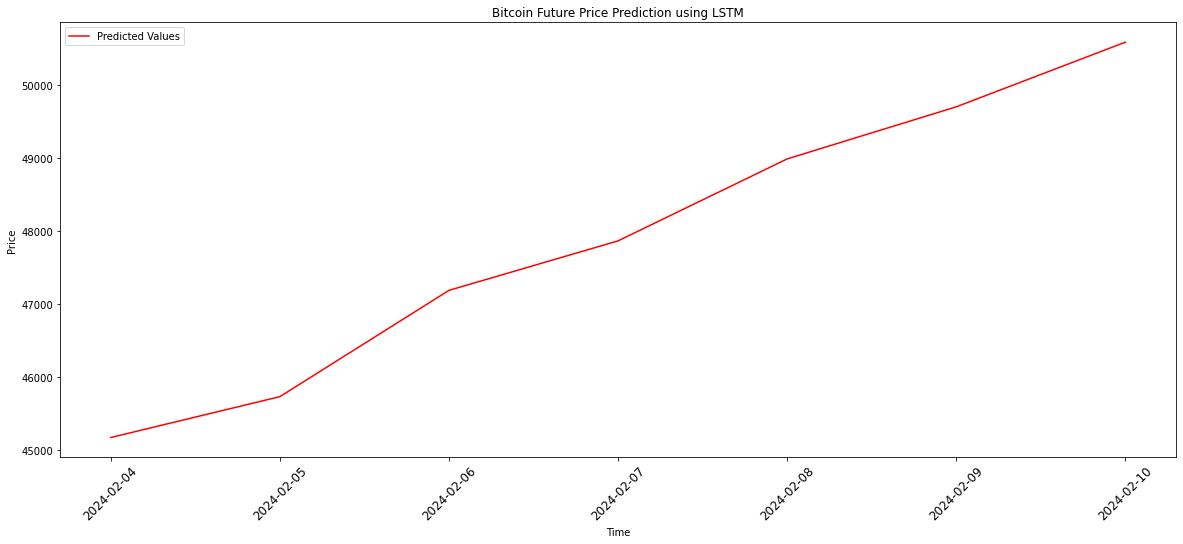

In [40]:
#x = [i for i in range(0, y_train.shape[0]+y_pred.shape[0])]
ticks = pd.to_datetime(future_prices['Date']).dt.date.tolist()

plt.figure(figsize=(20, 8))
# Plot y_train with blue color
#plt.plot(ticks, future_prices['ActualPrice'], 
#         label='True Values', color='blue')

# Plot test_pred with red color
plt.plot(ticks, future_prices['PredictedPrice'].tolist(), label='Predicted Values', color='red')

plt.title('Bitcoin Future Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(ticks, rotation = 45, fontsize=12)
plt.legend()
plt.show()